<a href="https://colab.research.google.com/github/Stephanie-DS/takehome-stephanie-workingcopy/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import nltk
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


In [ ]:
#%% import data

url = 'https://raw.githubusercontent.com/Pivotal-Life-Sciences-DS/takehome-stephanie/main/askscience_data.csv'
df = pd.read_csv(url)
df = df[df.score!=df.score.max()]
df = df[~df.tag.isin(['Meta', 'META'])]


<Axes: xlabel='score'>

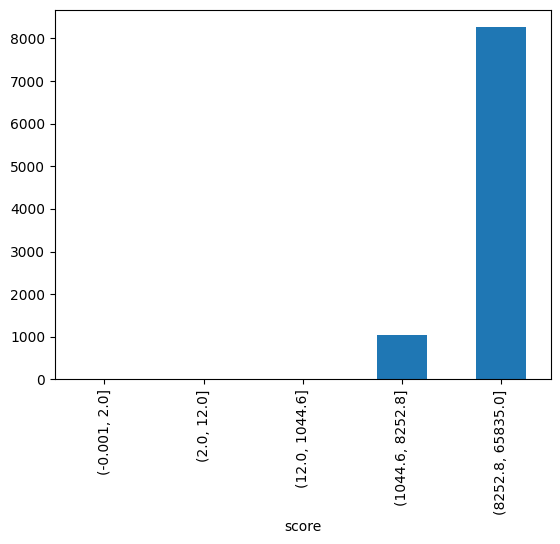

In [ ]:
# Let's see a histogram of the scores in this dataset.
scoresqfloor = df.groupby(pd.qcut(df.score, 5, duplicates="drop"))['score'].min().plot.bar()
scoresqfloor
# The 60th percentile starts around 1000-- forms the "elbow"
# For simplicity, I'm choosing 1000 upvotes as a natural break for success

In [ ]:
df['is_success'] = df['score']>=1000
df_success = df[df.is_success==True]
df_not_success = df[df.is_success==False]
success_body = ''.join(df_success['body'].fillna(" ").tolist())
success_title = ''.join(df_success['title'].fillna(" ").tolist())
not_success_body = ''.join(df_not_success['body'].fillna(" ").tolist())
not_success_title = ''.join(df_not_success['title'].fillna(" ").tolist())

#body includes Thank, https, edit,

Text(0.5, 1.0, 'Score: Less than 1000')

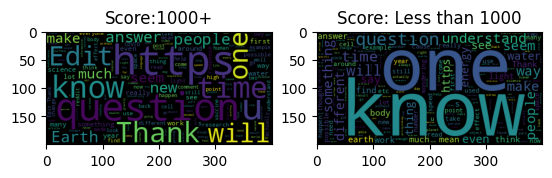

In [ ]:
wc_s = WordCloud().generate(success_body)
wc_n = WordCloud().generate(not_success_body)

plt.subplot(1, 2, 1)
plt.imshow(wc_s)
plt.title('Score:1000+')
plt.subplot(1, 2, 2)
plt.imshow(wc_n)
plt.title('Score: Less than 1000')

In [ ]:
#%% some histograms


ax = df['score'].plot.hist(bins=12, alpha=0.5)



#%% more specific EDA

# wanted to see the highest score. It's a net neutrality post.
# Second highest is a stephen hawking megathread
max = df[df.score==df.score.max()]

# see avg score in topics
tag_scores = df.groupby('tag')['score'].mean()
tag_scores_med = df.groupby('tag')['score'].median().sort_values(ascending=False)
df.groupby('tag')['score'].mean().plot.barh()
#things tagged meta are much higher
# some topics def higher than others


df.groupby(pd.cut(df.a, 80))['inc'].mean().plot()

# author post count
authorcount = df.groupby('author').size().sort_values(ascending=False)
authorcount = authorcount.to_frame(name='author_post_count')
authorcount.iloc[0]=0 # I want to remove counts for Deleted users
authorcount.iloc[1]=0 # i want to neutralize the mods' counts, too
df['authorcount'] = df['author'].replace(authorcount.index, authorcount['author_post_count'])

#nonlinear relationships.
# need to take the 0 posts out when I do this
# 12 looks like an outlier, is it? yep, it's this one person
author_postcount_scores = df.groupby('authorcount')['score'].mean()
author_count_scores_med = df.groupby('authorcount')['score'].median()
df_i = rawdf[df.author == 'inquilinekea'] # yeah it's this one author

# Length of title
df['title_len'] = df['title'].str.len()
title_len_scores = df.groupby(pd.cut(df.title_len, 10))['score'].mean()
title_len_scores = df.groupby(pd.cut(df.title_len, 10))['score'].median()
df.groupby(pd.cut(df.title_len, 10))['score'].median().plot.barh()
title_check = df[df.title_len > 270]
title_check = df[(df.title_len < 270) & (df.title_len >241)]
df.groupby(pd.qcut(df.title_len, 10))['score'].median().plot.barh()

# Length of post
df['body_len'] = df['body'].str.len().fillna(0)
body_len_scores = df.groupby(pd.cut(df.body_len, 10))['score'].mean()
body_len_scores = df.groupby(pd.cut(df.body_len, 40))['score'].median()
body_len_scoresq = df.groupby(pd.qcut(df.body_len, 40, duplicates='drop'))['score'].mean()
df.groupby(pd.cut(df.body_len, 10, duplicates='drop'))['score'].median().plot.barh()
df.groupby(pd.qcut(df.body_len, 10, duplicates='drop'))['score'].mean().plot.barh()
title_check = df[df.title_len > 270]
title_check = df[(df.title_len < 270) & (df.title_len >241)]

# title has AMA
df['is_ama'] = df['title'].str.contains("AMA")
is_ama_med = df.groupby('is_ama')['score'].median().sort_values(ascending=False)

#megathread
df['is_megathread'] = df['title'].str.contains("Megathread", case=False)
df.groupby('is_megathread')['score'].median().sort_values(ascending=False).plot.barh()
is_megathread_med = df.groupby('is_ama')['score'].median().sort_values(ascending=False)

# title has question mark - I could refine this
df['contains_question'] = df['title'].str.contains("?", regex=False)
df.groupby('contains_question')['score'].median().sort_values(ascending=False).plot.barh()
df_no_q = df[df.contains_question==False] #they're all the mod, though

#capitalize your title
df['no_capitalization'] = df['title'].str.islower()
df.groupby('no_capitalization')['score'].median().sort_values(ascending=False).plot.barh()


In [ ]:
#tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = [success_body,
          not_success_body]


df_corpus = pd.DataFrame({"texts": corpus})
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_separate = tfidf_vectorizer.fit_transform(df_corpus["texts"])

df_tfidf = pd.DataFrame(
    tfidf_separate.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=df_corpus.index
)
df_tf = df_tfidf.T

In [ ]:
df_tf['dif'] = df_tf[0]-df_tf[1]
df_tf.sort_values('dif', ascending=False, inplace=True)
df_tf.head(20)

,0,1,dif
edit,0.233262,0.056146,0.177116
https,0.280175,0.147384,0.132791
com,0.194168,0.103520,0.090648
www,0.188955,0.098841,0.090114
thank,0.100342,0.034507,0.065835
org,0.101645,0.038601,0.063044
http,0.101645,0.040355,0.061290
thanks,0.123798,0.064334,0.059464
cern,0.051282,0.000000,0.051282
answers,0.065157,0.018131,0.047026


In [ ]:
# temp: can make a feature
top_20 = list(df_tf.head(20).index.values)
bottom_20 = list(df_tf.tail(20).index.values)

has_top_20 =[0]

for text in df.body.fillna(" "):
  for word in top_20:
    if word in text:
      contains=True
    else:
      contains=False
    has_top_20.append(contains)

has_bottom_20 =[0]

for text in df.body.fillna(" "):
  for word in bottom_20:
    if word in text:
      contains=True
    else:
      contains=False
    has_bottom_20.append(contains)

In [ ]:
bottom_20


['having',
 'point',
 'way',
 'particles',
 'water',
 'speed',
 'think',
 'say',
 'electrons',
 'electron',
 'don',
 'light',
 'different',
 've',
 'question',
 'like',
 'understand',
 'know',
 'energy',
 'does']